In [1]:
# libraries and modules
# data availability
import requests
import zipfile
from pathlib import Path
# data preparation
import scipy.io
import pandas as pd
import numpy as np
import datetime
from scipy.stats import kurtosis, skew
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# modeling
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

Using TensorFlow backend


In [2]:
# config
# %matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

In [32]:
import os

# Specify the path to the folder containing the files
folder_path = "C:/Users/shruthi/Desktop/Mine/BMS/5.+Battery+Data+Set"  # Replace with the actual folder path

# List all files in the specified folder
file_list = os.listdir(folder_path)

# Iterate through the list of files and process them
for file_name in file_list:
    # Check if the item is a file (not a subdirectory)
    if os.path.isfile(os.path.join(folder_path, file_name)):
        # Process the file
        print(f"Processing file: {file_name}")
        
        # You can read, open, or perform any other operations on the file here
        # For example, open and read the file content
        with open(os.path.join(folder_path, file_name), 'r') as file:
            content = file.read()
            # Do something with the content


In [33]:
column_structure = {
    "discharge": [
      "voltage_measured",
      "current_measured",
      "temperature_measured",
      "current_charge",
      "voltage_charge",
      "time",
      "capacity",
    ],
    "impedance": [
      "sense_current",
      "battery_current",
      "current_ratio",
      "battery_impedance",
      "rectified_impedance",
      "re",
      "rct",
    ],
    "charge": [
     "voltage_measured",
     "current_measured",
     "temperature_measured",
     "current_charge",
     "voltage_charge",
     "time",
    ],
}

In [34]:
def _convert_row_data_to_df(row_data, columns):
  data_dict = {
      column: pd.Series(row_data[0][idx][0][:]) for idx, column in enumerate(columns)
  }
  data_df = pd.DataFrame(data=data_dict)
  return data_df

In [35]:
def _convert_data_dict_to_df(data_dict, data_key, data_type):
  dfs = []
  for val in data_dict[data_key][data_type]:
    val_df = val[3].copy()
    val_df["type"] = val[0]
    val_df["temp"] = val[1]
    val_df["time_exp"] = val[2]
    dfs.append(val_df)

  return pd.concat(dfs, ignore_index=True, sort=False)

In [36]:
def load_mat(path):
  data_mat = scipy.io.loadmat(path)
  data_key = list(data_mat.keys())[-1]
  data_dict = {
      data_key: {
          "discharge": [],
          "impedance": [],
          "charge":    [],
      }
  }

  for idx, row in enumerate(data_mat[data_key][0][0][0][0]):
    row_type = row[0][0]
    row_temp = row[1][0][0]
    row_time = datetime.datetime(*map(int, row[2][0]))
    row_data = row[3][0]
    row_data_df = _convert_row_data_to_df(row_data, column_structure[row_type])
    # special case
    if "time" in row_data_df.columns:
      timedelta_col = pd.to_timedelta(row_data_df["time"], unit='s')
      row_data_df["time"] = row_time + timedelta_col

    data_dict[data_key][row_type].append([row_type, row_temp, row_time, row_data_df])

  discharge_data_df = _convert_data_dict_to_df(data_dict, data_key, "discharge")
  impedance_data_df = _convert_data_dict_to_df(data_dict, data_key, "impedance")
  charge_data_df = _convert_data_dict_to_df(data_dict, data_key, "charge")

  return pd.concat([discharge_data_df, impedance_data_df, charge_data_df], ignore_index=True, sort=False)
     

In [80]:

mats = [mat for mat in Path(".").rglob("*.mat")]
mats = sorted(mats)
print(*mats, sep="\n")
     

5. Battery Data Set\1. BatteryAgingARC-FY08Q4\B0005.mat
5. Battery Data Set\1. BatteryAgingARC-FY08Q4\B0006.mat
5. Battery Data Set\1. BatteryAgingARC-FY08Q4\B0007.mat
5. Battery Data Set\1. BatteryAgingARC-FY08Q4\B0018.mat
5. Battery Data Set\2. BatteryAgingARC_25_26_27_28_P1\B0025.mat
5. Battery Data Set\2. BatteryAgingARC_25_26_27_28_P1\B0026.mat
5. Battery Data Set\2. BatteryAgingARC_25_26_27_28_P1\B0027.mat
5. Battery Data Set\2. BatteryAgingARC_25_26_27_28_P1\B0028.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0025.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0026.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0027.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0028.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0029.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0030.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0031.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0032.mat
5. Battery Data Set\3. BatteryAgingARC_25-44\B0033.mat
5. Battery Data Set\3. Ba

In [86]:
def load_data(battery_file_path):
  mat = scipy.io.loadmat(battery_file_path)
  battery = Path(battery_file_path).stem
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []

  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [39]:
battery_1 = mats[0]
mat_df = load_mat(battery_1)

In [40]:
dataset, capacity = load_data(battery_1)

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


In [41]:
dataset.head(5)

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


In [42]:
dataset.describe()

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


In [43]:
dataset.shape

(50285, 10)

In [82]:
dataset.tail(5)

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
50280,168,24,2008-05-27 20:45:42,1.325079,3.579262,-0.001569,34.864823,0.0006,0.0,2781.312
50281,168,24,2008-05-27 20:45:42,1.325079,3.581964,-0.003067,34.814770,0.0006,0.0,2791.062
50282,168,24,2008-05-27 20:45:42,1.325079,3.584484,-0.003079,34.676258,0.0006,0.0,2800.828
50283,168,24,2008-05-27 20:45:42,1.325079,3.587336,0.001219,34.565580,0.0006,0.0,2810.640
50284,168,24,2008-05-27 20:45:42,1.325079,3.589937,-0.000583,34.405920,0.0006,0.0,2820.390


In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cycle                 50285 non-null  int64         
 1   ambient_temperature   50285 non-null  uint8         
 2   datetime              50285 non-null  datetime64[ns]
 3   capacity              50285 non-null  float64       
 4   voltage_measured      50285 non-null  float64       
 5   current_measured      50285 non-null  float64       
 6   temperature_measured  50285 non-null  float64       
 7   current_load          50285 non-null  float64       
 8   voltage_load          50285 non-null  float64       
 9   time                  50285 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), uint8(1)
memory usage: 3.5 MB


In [45]:
dataset.dtypes
     

cycle                            int64
ambient_temperature              uint8
datetime                datetime64[ns]
capacity                       float64
voltage_measured               float64
current_measured               float64
temperature_measured           float64
current_load                   float64
voltage_load                   float64
time                           float64
dtype: object

In [46]:
dataset.isnull().sum()

cycle                   0
ambient_temperature     0
datetime                0
capacity                0
voltage_measured        0
current_measured        0
temperature_measured    0
current_load            0
voltage_load            0
time                    0
dtype: int64

Text(0.5, 1.0, 'Discharge B0005')

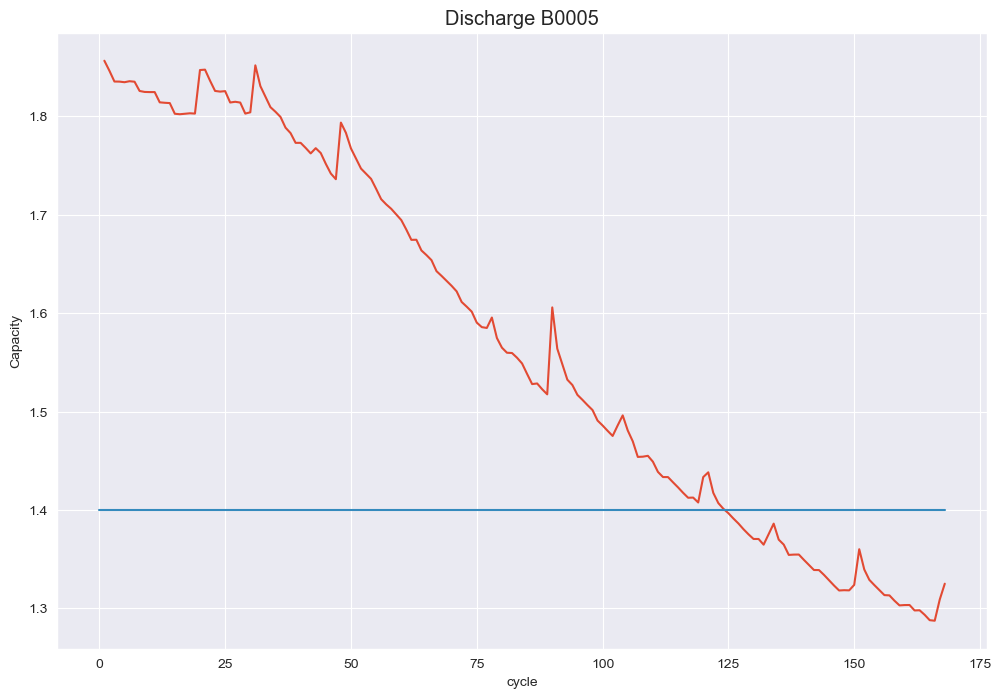

In [47]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

<Figure size 1200x800 with 0 Axes>

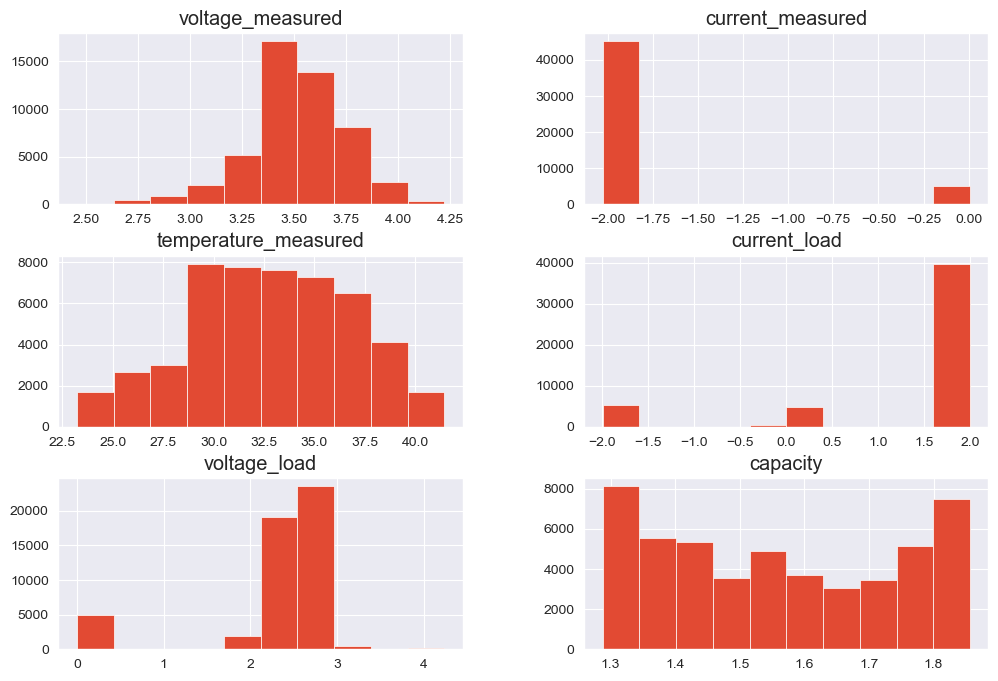

In [48]:
# Discharge Histogram
columns_of_interest = ["voltage_measured", "current_measured", "temperature_measured", "current_load", "voltage_load", "capacity"]

plt.figure()
dataset.loc[:, columns_of_interest].hist()

plt.show()

In [49]:

attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Text(0.5, 1.0, 'Discharge B0005')

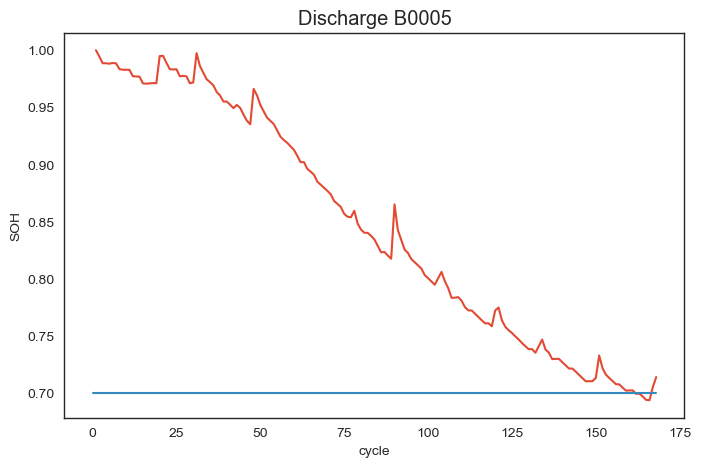

In [50]:

plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [51]:

columns_of_interest = ['capacity', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']
data = dataset[columns_of_interest].copy()

means = data.apply(np.mean)
variances = data.apply(np.var)
skewnesses = skew(data)
kurt = kurtosis(data)

print(f"Means:\n{means}", f"Variances:\n{variances}", f"Skewness:\n{skewnesses}", f"Kurtosis:\n{kurt}", sep="\n\n")

Means:
capacity                   1.560345
voltage_measured           3.515268
current_measured          -1.806032
temperature_measured      32.816991
current_load               1.362700
voltage_load               2.308406
time                    1546.208924
dtype: float64

Variances:
capacity                     0.033262
voltage_measured             0.053720
current_measured             0.372705
temperature_measured        15.899963
current_load                 1.725769
voltage_load                 0.640468
time                    821980.277682
dtype: float64

Skewness:
[ 0.11465034 -0.43812723  2.61797032 -0.13610722 -1.82835115 -2.2611816
  0.06225828]

Kurtosis:
[-1.41193035  1.17346376  4.85385007 -0.6451763   1.77536324  4.0357801
 -1.11246968]


In [52]:
col = dataset["voltage_load"].copy()
col

0        0.000
1        4.206
2        3.062
3        3.030
4        3.011
         ...  
50280    0.000
50281    0.000
50282    0.000
50283    0.000
50284    0.000
Name: voltage_load, Length: 50285, dtype: float64

In [53]:

from scipy.stats import boxcox

col = dataset["voltage_load"].copy()
transformed_col = boxcox(x=col, lmbda=0.5)

kurt = kurtosis(col)
transformed_kurt = kurtosis(transformed_col)
print(f"Regular Kurtosis:\n{kurt}", f"Transformed Kurtosis @ {0.5}:\n{transformed_kurt}", sep="\n\n")

Regular Kurtosis:
4.035780103516682

Transformed Kurtosis @ 0.5:
4.84189040726057


In [54]:
from scipy.stats import boxcox

col = dataset["current_measured"].copy()
transformed_col = boxcox(x=col, lmbda=0.5)

kurt = kurtosis(col)
transformed_kurt = kurtosis(transformed_col)
print(f"Regular Kurtosis:\n{kurt}", f"Transformed Kurtosis @ {0.5}:\n{transformed_kurt}", sep="\n\n")

Regular Kurtosis:
4.853850068705413

Transformed Kurtosis @ 0.5:
nan


In [55]:
C_0 = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C_0])
soh = pd.DataFrame(data=soh, columns=['SoH'])
target = soh.copy().to_numpy()
target.shape

(50285, 1)

In [56]:

attribs=['capacity', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs].copy()

In [57]:
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
train_dataset.shape

(50285, 7)

In [58]:
train_dataset

array([[1.00000000e+00, 9.82216203e-01, 9.93912495e-01, ...,
        4.99849880e-01, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.81795921e-01, 9.95593528e-01, ...,
        4.99849880e-01, 9.92449269e-01, 4.54740810e-03],
       [1.00000000e+00, 8.59640432e-01, 8.13621166e-03, ...,
        5.00400320e-05, 7.22510618e-01, 9.67499622e-03],
       ...,
       [6.61238996e-02, 6.38738471e-01, 9.94807358e-01, ...,
        5.00150120e-01, 0.00000000e+00, 7.58983848e-01],
       [6.61238996e-02, 6.40352345e-01, 9.96917596e-01, ...,
        5.00150120e-01, 0.00000000e+00, 7.61642758e-01],
       [6.61238996e-02, 6.41824310e-01, 9.96032820e-01, ...,
        5.00150120e-01, 0.00000000e+00, 7.64284866e-01]])

In [59]:
base_model = Sequential()
base_model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
base_model.add(Dense(8, activation='relu'))
base_model.add(Dense(8, activation='relu'))
base_model.add(Dropout(rate=0.25))
base_model.add(Dense(1))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


In [60]:
base_model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

In [61]:

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=8, max_value=32, step=4),
                    activation='relu',
                    input_dim=train_dataset.shape[1]))

    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model.add(Dense(units=hp.Int(f'units_layer_{i}', min_value=8, max_value=32, step=4),
                        activation='relu'))

    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_absolute_error')

    return model

In [62]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # The number of different models to try
    executions_per_trial=1,  # The number of times to train each model
    directory='random_search',
    project_name='battery_soh_optimization'
)

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [64]:
optimized_model = Sequential()
optimized_model.add(Dense(16, activation='relu', input_dim=train_dataset.shape[1], kernel_regularizer=L1(0.01)))
optimized_model.add(Dense(16, activation='relu'))
optimized_model.add(Dropout(rate=0.1))
optimized_model.add(Dense(1))
optimized_model.summary()

optimizer = Adam(learning_rate=0.00010948067065592716,
                 beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimized_model.compile(optimizer=optimizer, loss='mean_absolute_error')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16)                128       
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [65]:

base_model.fit(x=train_dataset, y=target, batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 6s 2ms/step - loss: 0.1199
Epoch 2/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0273
Epoch 3/50
2012/2012 [==============================] - 5s 2ms/step - loss: 0.0253
Epoch 4/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0250
Epoch 5/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0251
Epoch 6/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0251
Epoch 7/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0249
Epoch 8/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0247
Epoch 9/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0247
Epoch 10/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0245
Epoch 11/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0248
Epoch 12/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0245
E

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

optimized_model.fit(x=train_dataset, y=target, batch_size=25, epochs=50, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
1610/1610 [==============================] - 5s 2ms/step - loss: 0.4045 - val_loss: 0.1700
Epoch 2/50
1610/1610 [==============================] - 4s 2ms/step - loss: 0.2068 - val_loss: 0.1237
Epoch 3/50
1610/1610 [==============================] - 4s 2ms/step - loss: 0.1394 - val_loss: 0.0751
Epoch 4/50
1610/1610 [==============================] - 4s 2ms/step - loss: 0.1098 - val_loss: 0.0501
Epoch 5/50
1610/1610 [==============================] - 4s 2ms/step - loss: 0.0897 - val_loss: 0.0333
Epoch 6/50
1610/1610 [==============================] - 3s 2ms/step - loss: 0.0732 - val_loss: 0.0255
Epoch 7/50
1610/1610 [==============================] - 4s 2ms/step - loss: 0.0608 - val_loss: 0.0245
Epoch 8/50
1610/1610 [==============================] - 4s 2ms/step - loss: 0.0487 - val_loss: 0.0217
Epoch 9/50
1610/1610 [==============================] - 4s 2ms/step - loss: 0.0387 - val_loss: 0.0164
Epoch 10/50
1610/1610 [==============================] - 4s 2ms/step - loss: 0.030

In [68]:
battery_2 = mats[1]
dataset_val, capacity_val = load_data(battery_2)
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]


In [69]:
dataset_val.head(5)

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,2.035338,4.179800,-0.002366,24.277568,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,2.035338,4.179823,0.000434,24.277073,-0.0006,4.195,16.781
2,1,24,2008-04-02 15:25:41,2.035338,3.966528,-2.014242,24.366226,-1.9990,3.070,35.703
3,1,24,2008-04-02 15:25:41,2.035338,3.945886,-2.008730,24.515123,-1.9990,3.045,53.781
4,1,24,2008-04-02 15:25:41,2.035338,3.930354,-2.013381,24.676053,-1.9990,3.026,71.922


In [70]:
dis_ele.head(5)

,cycle,datetime,capacity,SoH
0,1,2008-04-02 15:25:41,2.035338,1.000000
1,2,2008-04-02 19:43:48,2.025140,0.994990
2,3,2008-04-03 00:01:06,2.013326,0.989185
3,4,2008-04-03 04:16:37,2.013285,0.989165
4,5,2008-04-03 08:33:25,2.000528,0.982898


In [71]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred_base = base_model.predict(sc.fit_transform(dataset_val[attrib]))
soh_pred_opt = optimized_model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred_base.shape, soh_pred_opt.shape, sep="\n")
     

1572/1572 [==============================] - 2s 1ms/step
(50285, 1)
(50285, 1)


In [72]:
C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH_Base'] = soh_pred_base
new_soh['NewSoH_Optimized'] = soh_pred_opt
new_soh = new_soh.groupby(['cycle']).mean().reset_index()

In [73]:

new_soh.head(5)

,cycle,SoH,NewSoH_Base,NewSoH_Optimized
0,1,1.000000,0.982353,0.983023
1,2,0.994990,0.979467,0.979703
2,3,0.989185,0.975861,0.975840
3,4,0.989165,0.975791,0.975828
4,5,0.982898,0.971889,0.971621


In [74]:

# Base Model:
# evaluate the model using various metrics
mae = metrics.mean_absolute_error(new_soh['SoH'], new_soh['NewSoH_Base'])
mse = metrics.mean_squared_error(new_soh['SoH'], new_soh['NewSoH_Base'])
rmse = metrics.mean_squared_error(new_soh['SoH'], new_soh['NewSoH_Base'], squared=False)
r2 = metrics.r2_score(new_soh['SoH'], new_soh['NewSoH_Base'])

# print the evaluation results
print("============ BASE MODEL ============")
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R-squared:', r2)

============ BASE MODEL ============
MAE: 0.06695187717161911
MSE: 0.00619269761589919
RMSE: 0.07869369489291496
R-squared: 0.5937310871669401


In [75]:
# Optimized Model:
# evaluate the model using various metrics
mae = metrics.mean_absolute_error(new_soh['SoH'], new_soh['NewSoH_Optimized'])
mse = metrics.mean_squared_error(new_soh['SoH'], new_soh['NewSoH_Optimized'])
rmse = metrics.mean_squared_error(new_soh['SoH'], new_soh['NewSoH_Optimized'], squared=False)
r2 = metrics.r2_score(new_soh['SoH'], new_soh['NewSoH_Optimized'])

# print the evaluation results
print("============ Optimized MODEL ============")
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R-squared:', r2)

============ Optimized MODEL ============
MAE: 0.0660762109253318
MSE: 0.005946786020263546
RMSE: 0.07711540715229057
R-squared: 0.6098639977026388


Text(0.5, 1.0, 'Discharge B0006')

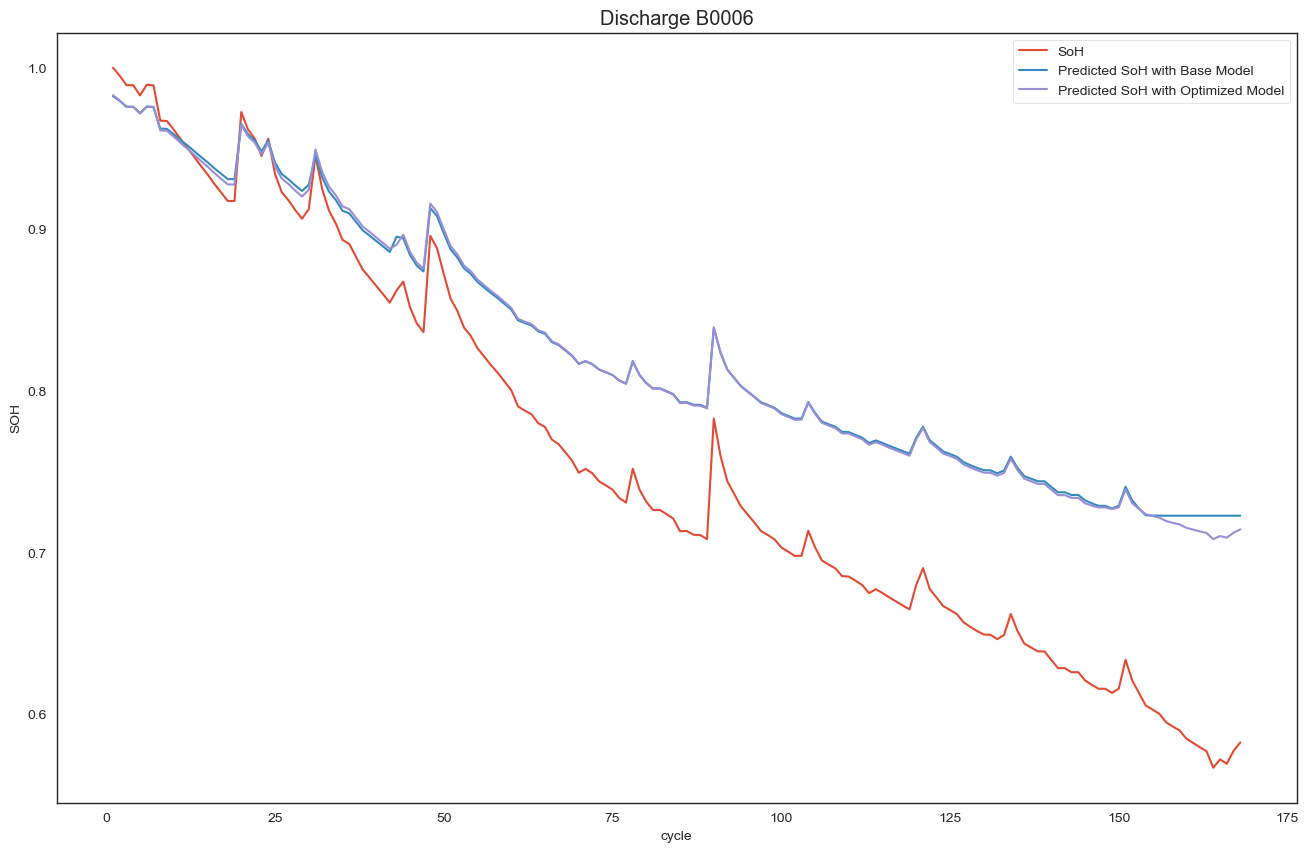

In [76]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH_Base', 'NewSoH_Optimized']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH_Base'], label='Predicted SoH with Base Model')
plt.plot(plot_df['cycle'], plot_df['NewSoH_Optimized'], label='Predicted SoH with Optimized Model')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

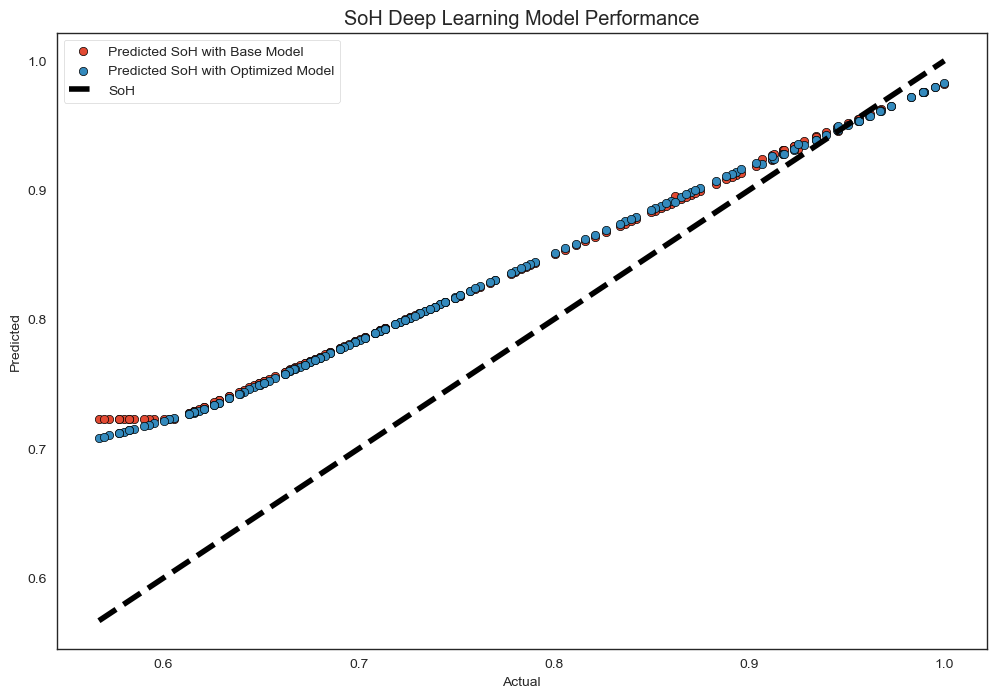

In [77]:
# plot the predicted values against the actual values
fig, ax = plt.subplots()
ax.scatter(new_soh['SoH'], new_soh['NewSoH_Base'], edgecolors=(0, 0, 0), label='Predicted SoH with Base Model')
ax.scatter(new_soh['SoH'], new_soh['NewSoH_Optimized'], edgecolors=(0, 0, 0),label='Predicted SoH with Optimized Model')

ax.plot([new_soh['SoH'].min(), new_soh['SoH'].max()], [new_soh['SoH'].min(), new_soh['SoH'].max()], 'k--', lw=4, label='SoH')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('SoH Deep Learning Model Performance')
plt.legend()
plt.show()